# Stock Market Prediction of the Short-term Impact of President Trump's Tweet


## Authors
* **Jiaxuan Ren** - [Jiaxuan-Ren](https://github.com/Jiaxuan-Ren)
* **Kaihan Zhu**  - [zhukaihan](https://github.com/zhukaihan)

The following notebook processes data, trains different models, and generate graphs. For detailed analysis, please see the report in PDF version. 

### Imports and utility functions

In [134]:
# data processing
import numpy as np
import pandas as pd
from collections import defaultdict
import datetime as dt
from dateutil import tz
from dateutil import parser
import pytz
import string
import re
import gzip
import random

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# plot graphs
%matplotlib notebook
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# some utility functions
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )
        
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

def readCSV(path):
    f = open(path, 'r')
    f.readlines()
    for l in f:
        yield l.strip().split(',')

def strGMTToNYTime(s):
    date_time_str = s
    date_time_obj = dt.datetime.strptime(date_time_str, '%m-%d-%Y %H:%M:%S')

    timezone = pytz.timezone('America/New_York')
    timezone_date_time_obj = timezone.localize(date_time_obj)
    return timezone_date_time_obj

def strSPToNYTime(s):
    date_time_str = s
    date_time_obj = parser.parse(date_time_str + " -06")

    timezone = pytz.timezone('America/New_York')
    return date_time_obj

def timeToStr(t):
    toTimeZone = tz.gettz('America/New_York')
    return t.astimezone(toTimeZone).strftime("%Y-%m-%d %H:%M:%S EST")

def strToTime(s):
    return parser.parse(s)


### Read and process Trump's tweets

The file "tweet_DonaldTrump_15_17.csv" contains all of Trump's tweets from 2015 to 2017, excluding retweets. 

In [125]:
data = []
f = open("tweet_DonaldTrump_15_17.csv", "r", encoding = 'utf-8')
fl = f.readlines()
headlineRead = False
for line in fl:
    if not headlineRead:
        headlineRead = True
        continue
    data.append(line.strip().split(','))
data = np.array(data, dtype = object)

Cleans the data, removing links, punctuations, and convert time to Eastern Time. 

In [126]:
cleaned_data = []
for d in data:
    text = d[0].lower()
    text = re.sub('http\S+|www.\S+|@\S+', '', text).translate(str.maketrans('', '', string.punctuation)).strip()
    if text == "": continue
    time = strGMTToNYTime(d[1])
    cleaned_data.append([time, text])
data = np.array(cleaned_data, dtype = object)


### Read and process stock market data

The file "15.csv", "16.csv", and "17.csv" contains all of the trade data of SPY, a S&P 500 ETF, from 2015 to 2017, to milliseconds resolution. The data is obtained from NYSE Trade and Quote database, through Wharton Research Data Services. 

Since the data is too large, we trimmed the data to seconds resolution, using the first tick of that second to be the trading price of that second. 

In [288]:
sp_tick_15 = pd.read_csv("15.csv", sep = ',', header = 0)
sp_tick_15 = sp_tick_15.values

In [290]:
sp_tick_16 = pd.read_csv("16.csv", sep = ',', header = 0)
sp_tick_16 = sp_tick_16.values

In [320]:
sp_tick_17 = pd.read_csv("17.csv", sep = ',', header = 0)
sp_tick_17 = sp_tick_17.values

In [357]:
sp_ticks = [[getTickTime(sp_tick_15[0]), sp_tick_15[0, 4]]]

ny_timezone = pytz.timezone('America/New_York')
getTickTime = lambda t: ny_timezone.localize(parser.parse(str(t[0]) + " " + t[1] + " EST"))

for t in log_progress(sp_tick_15, every = 10000):
    if getTickTime(t) - sp_ticks[-1][0] < dt.timedelta(seconds = 1):
        continue
    sp_ticks.append([getTickTime(t), t[4]])

sp_ticks.append([getTickTime(sp_tick_16[0]), sp_tick_16[0, 4]])

for t in log_progress(sp_tick_16, every = 10000):
    if getTickTime(t) - sp_ticks[-1][0] < dt.timedelta(seconds = 1):
        continue
    sp_ticks.append([getTickTime(t), t[4]])
    
sp_ticks.append([getTickTime(sp_tick_17[0]), sp_tick_17[0, 4]])

for t in log_progress(sp_tick_17, every = 10000):
    if getTickTime(t) - sp_ticks[-1][0] < dt.timedelta(seconds = 1):
        continue
    sp_ticks.append([getTickTime(t), t[4]])

In [358]:
np.save("sp_ticks", sp_ticks)

In [5]:
sp_ticks = np.load('sp_ticks.npy')

In [6]:
sp_ticks_np = np.array(sp_ticks)

In [60]:
print(sp_ticks_np[9000:9010])

[[datetime.datetime(2015, 1, 2, 12, 32, 19, 805000, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>)
  205.12]
 [datetime.datetime(2015, 1, 2, 12, 32, 20, 853000, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>)
  205.16]
 [datetime.datetime(2015, 1, 2, 12, 32, 21, 949000, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>)
  205.16]
 [datetime.datetime(2015, 1, 2, 12, 32, 23, 2000, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>)
  205.16]
 [datetime.datetime(2015, 1, 2, 12, 32, 24, 71000, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>)
  205.18]
 [datetime.datetime(2015, 1, 2, 12, 32, 25, 166000, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>)
  205.19]
 [datetime.datetime(2015, 1, 2, 12, 32, 26, 530000, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>)
  205.18]
 [datetime.datetime(2015, 1, 2, 12, 32, 27, 757000, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>)
  205.1699]
 

### Utility function to generate features for training with corresponding "frame seconds", defined as the time window after Trump's tweet. 

In [128]:
data = np.sort(data, axis = 0)

def getXy(data, sp_ticks_np, frameSecs):
    X = []
    y = []
    spI = 0
    for i in range(data.shape[0]):
        aX = data[i, 1]

        twitterTime = data[i, 0]

        while spI < sp_ticks_np.shape[0] and sp_ticks_np[spI, 0] < twitterTime: spI += 1
        # Now, spI is the tick after twitterTime. 
        # So the base tick is spI - 1. 
        if spI == 0 or spI >= sp_ticks_np.shape[0]: continue

        basePrice = sp_ticks_np[spI - 1, 1]

        # Search for the first tick after frameSecs. Start with spI. 
        spFrameI = spI

        while spFrameI < sp_ticks_np.shape[0] and sp_ticks_np[spFrameI, 0] < (twitterTime + dt.timedelta(seconds = frameSecs)): spFrameI += 1
        # Now spFrameI is the tick after twitterTime + frameSecs. 
        # What we want is spFrameI as it is the tick after twitterTime + frameSecs. 
        if spI == 0 or spFrameI >= sp_ticks_np.shape[0]: continue

        flucPrice = sp_ticks_np[spFrameI, 1]

        fluc = (flucPrice - basePrice) / basePrice

        if fluc is None:
            continue

        X.append(aX)
        y.append(fluc)
    #     print(timeToStr(data[i, 0]), fluc, timeToStr(sp_ticks_np[spI - 1, 0]), sp_ticks_np[spI - 1, 1], timeToStr(sp_ticks_np[spFrameI, 0]), sp_ticks_np[spFrameI, 1])
    return X, y

In [72]:
X[4000:4002]

['i love it when trump calls out msm for what they really are  cams starting to show crowds at rallies',
 'i love mexico but not the unfair trade deals that the us so stupidly makes with them really bad for us jobs only good for mexico']

In [73]:
y[4000:4002]

[0.0003175013817189546, -0.0001645742229745455]

## LinearRegression

We built and tested linear regression model using a variety of different parameters. 
* With increasing time frame, the absolute value of volatility increases. This is because as time increases the market should be more diverted from its original starting point. But the relative value of how the model outperforms the baseline does not necessarily increases. And it decreases as the time window becomes very long. This is also reasonable since the longer the time frame, the more uncertainty in the market and thus harder to predict. 
* The train accuracy always decreases as alpha increases. The validation accuracy first increase, and after reaching a maximum at alpha=10, then decreases. This is true for both absolute value of accuracy and relative accuracy against the baseline. At a very low alpha, the model overfits and makes the train accuracy significantly higher than the validation accuracy. At a very high alpha, the model underfits and makes both accuracy lower. 
* The adding of sigmoid does not cause a significant change in accuracy. This is reasonable as the value of volatility does not shift towards one side of the balance; thus, it is not necessary to balance the data again. 


### Accuracy vs different time window

In [278]:
frameSecss = [1, 3, 6, 10, 15, 30, 60, 120, 240, 480, 900, 20 * 60]
times = 10

train_accs = []
val_accs = []
train_base_accs_diff = []
val_base_accs_diff = []

for frameS in frameSecss:
    train_accs.append(0)
    val_accs.append(0)
    train_base_accs_diff.append(0)
    val_base_accs_diff.append(0)
    
    for i in range(times):
        # Get data with frameS
        X, y = getXy(data, sp_ticks_np, frameS)

        # Randomly Choose Val Data. 
        X = np.array(X)
        y = np.array(y)
        val_choices = np.random.choice(np.arange(X.shape[0]), int(X.shape[0] / 3), replace = False)
        val_X = X[val_choices]
        val_y = y[val_choices]
        train_mask = np.ones(X.shape[0], dtype=bool)
        train_mask[val_choices] = False
        train_X = X[train_mask]
        train_y = y[train_mask]

        # Transform Data into Tf-Idf
        vectorizer = TfidfVectorizer()
        train_X = vectorizer.fit_transform(train_X)
        val_X = vectorizer.transform(val_X)

        # Sigmoid
        train_y = 1 / (np.exp(-train_y) + 1)
        val_y = 1 / (np.exp(-val_y) + 1)

        # Train
        m = Ridge(alpha = 10)
        m.fit(train_X, train_y)

        train_pred = m.predict(train_X)
        val_pred = m.predict(val_X)

        spread = 0.00000
        center = 0.5

        def predSpread(y_pred, center, spread):
            y_pred_zero = y_pred * (y_pred > (center - spread)) < (center + spread)
            y_pred_pos = y_pred > (center + spread)
            y_pred_neg = y_pred < (center - spread)
            return (y_pred_pos) * 1 + (y_pred_neg * -1)

        train_X_percentage = [np.mean(train_y > 0.5), np.mean(train_y == 0.5), np.mean(train_y < 0.5)]
        val_X_percentage = [np.mean(val_y > 0.5), np.mean(val_y == 0.5), np.mean(val_y < 0.5)]
        popularity_predictor = np.argmax(train_X_percentage)
        train_base_acc = train_X_percentage[popularity_predictor]
        val_base_acc = val_X_percentage[popularity_predictor]

        train_pred_spread = predSpread(train_pred, center, spread)
        train_y_spread = predSpread(train_y, center, 0)
        val_pred_spread = predSpread(val_pred, center, spread)
        val_y_spread = predSpread(val_y, center, 0)

        train_acc = np.mean(train_pred_spread == train_y_spread)
        val_acc = np.mean(val_pred_spread == val_y_spread)

        train_accs[-1] += (train_acc) / times
        val_accs[-1] += (val_acc) / times
        train_base_accs_diff[-1] += (train_acc - train_base_acc) / times
        val_base_accs_diff[-1] += (val_acc - val_base_acc) / times

<IPython.core.display.Javascript object>


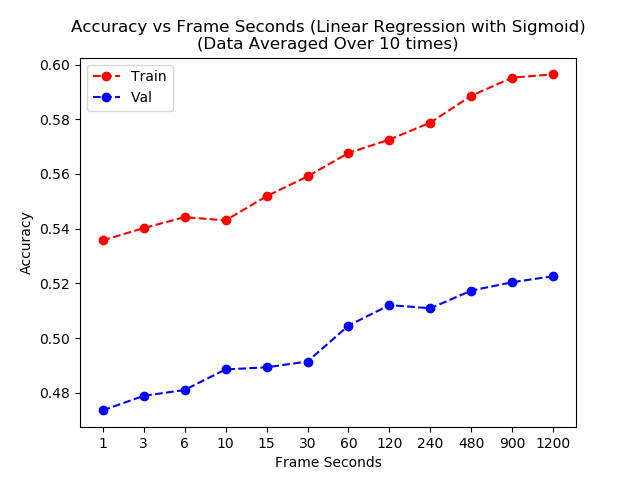

In [279]:
plt.figure()
x = frameSecss
xi = list(range(len(x)))
plt.plot(xi, train_accs, marker='o', linestyle='--', color='r', label='Train')
plt.plot(xi, val_accs, marker='o', linestyle='--', color='b', label='Val')
plt.xlabel("Frame Seconds")
plt.ylabel("Accuracy")
plt.xticks(xi, x)
plt.title("Accuracy vs Frame Seconds (Linear Regression with Sigmoid)\n(Data Averaged Over %d times)"%times)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


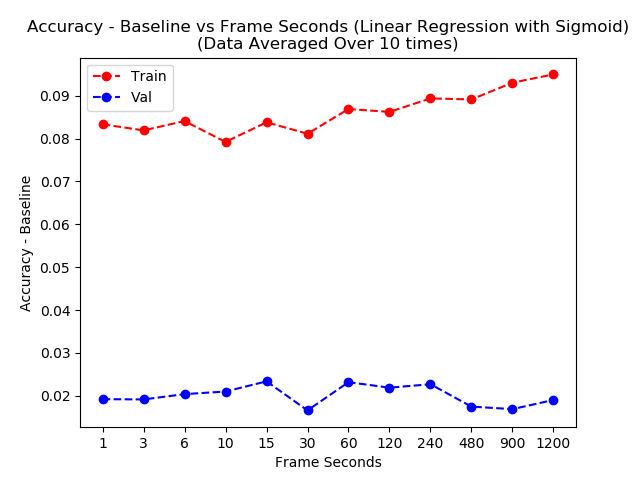

In [280]:
plt.figure()
x = frameSecss
xi = list(range(len(x)))
plt.plot(xi, train_base_accs_diff, marker='o', linestyle='--', color='r', label='Train')
plt.plot(xi, val_base_accs_diff, marker='o', linestyle='--', color='b', label='Val')
plt.xlabel("Frame Seconds")
plt.ylabel("Accuracy - Baseline")
plt.xticks(xi, x)
plt.title("Accuracy - Baseline vs Frame Seconds (Linear Regression with Sigmoid)\n(Data Averaged Over %d times)"%times)
plt.legend() 
plt.show()

### Accuracy with or without sigmoid

In [281]:
frameSecss = [240, 480, 1200]
sigmoids = [0, 1]

train_accs = []
val_accs = []
train_base_accs_diff = []
val_base_accs_diff = []
train_accs_sig = []
val_accs_sig = []
train_base_accs_diff_sig = []
val_base_accs_diff_sig = []

for frameS in frameSecss:
    # Get data with frameS
    X, y = getXy(data, sp_ticks_np, frameS)

    # Randomly Choose Val Data. 
    X = np.array(X)
    y = np.array(y)
    val_choices = np.random.choice(np.arange(X.shape[0]), int(X.shape[0] / 3), replace = False)
    val_X = X[val_choices]
    val_y = y[val_choices]
    train_mask = np.ones(X.shape[0], dtype=bool)
    train_mask[val_choices] = False
    train_X = X[train_mask]
    train_y = y[train_mask]

    # Transform Data into Tf-Idf
    vectorizer = TfidfVectorizer()
    train_X = vectorizer.fit_transform(train_X)
    val_X = vectorizer.transform(val_X)
    for sigmoid in sigmoids:

        if sigmoid == 1:
            # Sigmoid
            train_y = 1 / (np.exp(-train_y) + 1)
            val_y = 1 / (np.exp(-val_y) + 1)
            center = 0.5
        else:
            train_y = train_y
            val_y = val_y
            center = 0

        # Train
        m = Ridge(alpha = 10)
        m.fit(train_X, train_y)

        train_pred = m.predict(train_X)
        val_pred = m.predict(val_X)

        spread = 0.00000

        def predSpread(y_pred, center, spread):
            y_pred_zero = y_pred * (y_pred > (center - spread)) < (center + spread)
            y_pred_pos = y_pred > (center + spread)
            y_pred_neg = y_pred < (center - spread)
            return (y_pred_pos) * 1 + (y_pred_neg * -1)

        train_X_percentage = [np.mean(train_y > 0.5), np.mean(train_y == 0.5), np.mean(train_y < 0.5)]
        val_X_percentage = [np.mean(val_y > 0.5), np.mean(val_y == 0.5), np.mean(val_y < 0.5)]
        popularity_predictor = np.argmax(train_X_percentage)
        train_base_acc = train_X_percentage[popularity_predictor]
        val_base_acc = val_X_percentage[popularity_predictor]

        train_pred_spread = predSpread(train_pred, center, spread)
        train_y_spread = predSpread(train_y, center, 0)
        val_pred_spread = predSpread(val_pred, center, spread)
        val_y_spread = predSpread(val_y, center, 0)

        train_acc = np.mean(train_pred_spread == train_y_spread)
        val_acc = np.mean(val_pred_spread == val_y_spread)

        if sigmoid == 1:
            # Sigmoid
            train_accs_sig.append(train_acc)
            val_accs_sig.append(val_acc)
            train_base_accs_diff_sig.append(train_acc - train_base_acc)
            val_base_accs_diff_sig.append(val_acc - val_base_acc)
        else:
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            train_base_accs_diff.append(train_acc - train_base_acc)
            val_base_accs_diff.append(val_acc - val_base_acc)

<IPython.core.display.Javascript object>


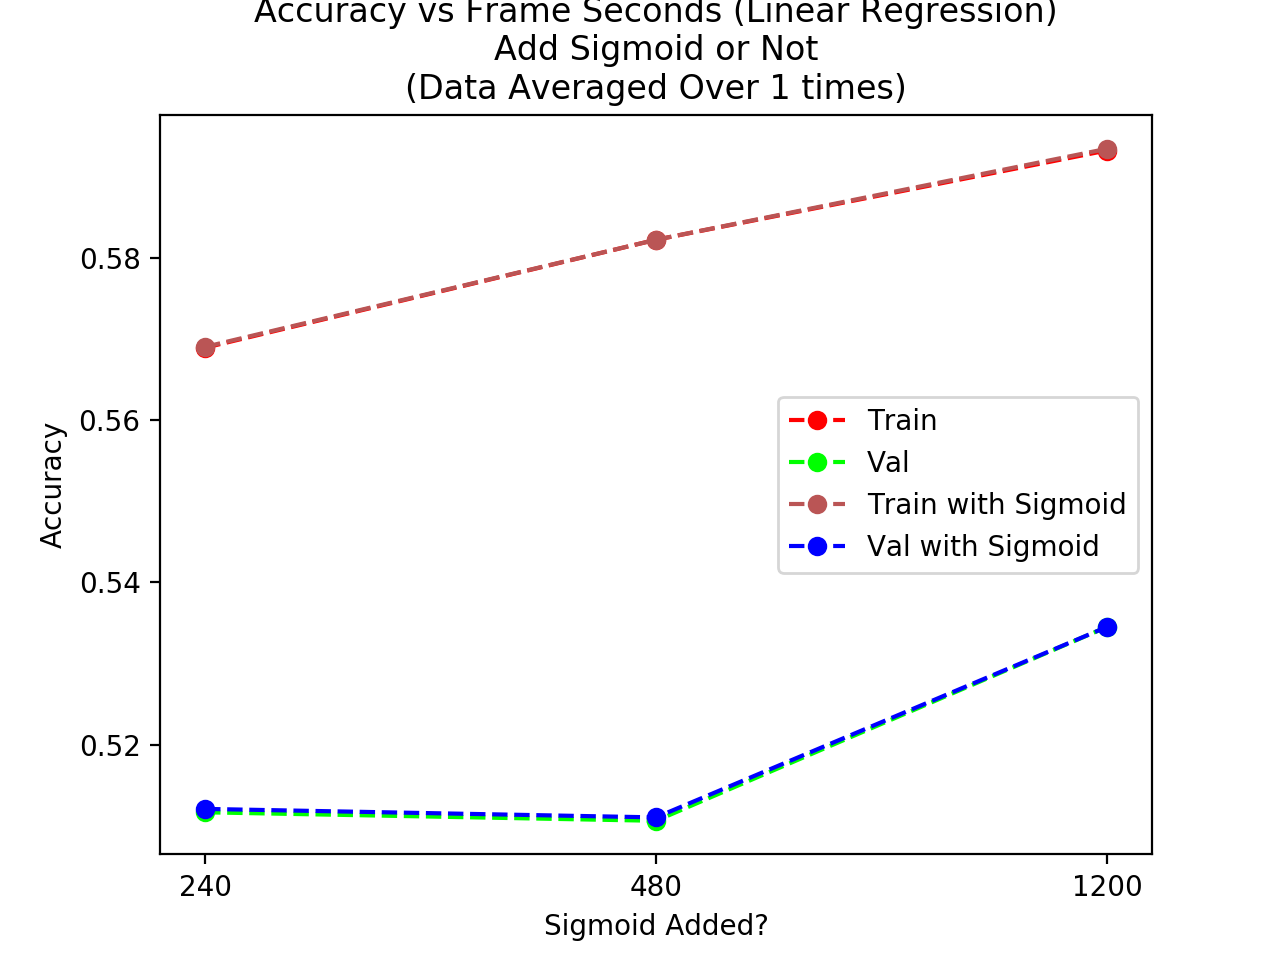

In [282]:
plt.figure()
x = frameSecss
xi = list(range(len(x)))
plt.plot(xi, train_accs, marker='o', linestyle='--', color='#FF0000', label='Train')
plt.plot(xi, val_accs, marker='o', linestyle='--', color='#00FF00', label='Val')
plt.plot(xi, train_accs_sig, marker='o', linestyle='--', color='#BA5555', label='Train with Sigmoid')
plt.plot(xi, val_accs_sig, marker='o', linestyle='--', color='#0000FF', label='Val with Sigmoid')
plt.xlabel("Sigmoid Added?")
plt.ylabel("Accuracy")
plt.xticks(xi, x)
plt.title("Accuracy vs Frame Seconds (Linear Regression)\nAdd Sigmoid or Not\n(Data Averaged Over %d times)"%1)
plt.legend()
plt.show()

### Accuracy vs different alpha values

In [206]:
# Get data with frameS
X, y = getXy(data, sp_ticks_np, 60)

# Randomly Choose Val Data. 
X = np.array(X)
y = np.array(y)
val_choices = np.random.choice(np.arange(X.shape[0]), int(X.shape[0] / 3), replace = False)
val_X = X[val_choices]
val_y = y[val_choices]
train_mask = np.ones(X.shape[0], dtype=bool)
train_mask[val_choices] = False
train_X = X[train_mask]
train_y = y[train_mask]

# Transform Data into Tf-Idf
vectorizer = TfidfVectorizer()
train_X = vectorizer.fit_transform(train_X)
val_X = vectorizer.transform(val_X)

# Sigmoid
train_y = 1 / (np.exp(-train_y) + 1)
val_y = 1 / (np.exp(-val_y) + 1)


alphas = [1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3]

train_accs = []
val_accs = []
train_base_accs_diff = []
val_base_accs_diff = []

for a in alphas:
    m = Ridge(alpha = a)
    m.fit(train_X, train_y)
    train_pred = m.predict(train_X)
    val_pred = m.predict(val_X)

    spread = 0.00000
    center = 0.5

    def predSpread(y_pred, center, spread):
        y_pred_zero = y_pred * (y_pred > (center - spread)) < (center + spread)
        y_pred_pos = y_pred > (center + spread)
        y_pred_neg = y_pred < (center - spread)
        return (y_pred_pos) * 1 + (y_pred_neg * -1)

    train_base_acc = np.mean(train_y > 0.5)
    val_base_acc = np.mean(val_y > 0.5)

    train_pred_spread = predSpread(train_pred, center, spread)
    train_y_spread = predSpread(train_y, center, 0)
    val_pred_spread = predSpread(val_pred, center, spread)
    val_y_spread = predSpread(val_y, center, 0)

    train_acc = np.mean(train_pred_spread == train_y_spread)
    val_acc = np.mean(val_pred_spread == val_y_spread)
    
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_base_accs_diff.append(train_acc - train_base_acc)
    val_base_accs_diff.append(val_acc - val_base_acc)



<IPython.core.display.Javascript object>


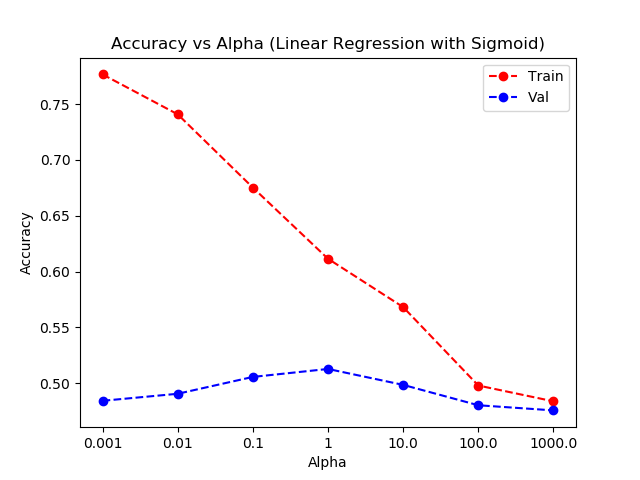

In [207]:
plt.figure()
x = alphas
xi = list(range(len(x)))
plt.plot(xi, train_accs, marker='o', linestyle='--', color='r', label='Train')
plt.plot(xi, val_accs, marker='o', linestyle='--', color='b', label='Val')
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.xticks(xi, x)
plt.title("Accuracy vs Alpha (Linear Regression with Sigmoid)")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


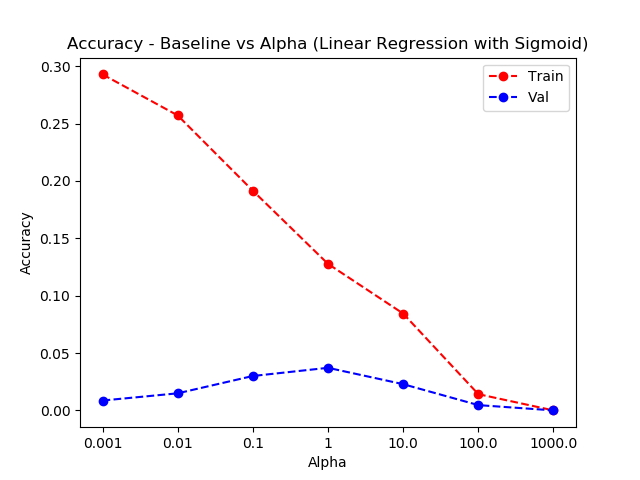

In [208]:
plt.figure()
x = alphas
xi = list(range(len(x)))
plt.plot(xi, train_base_accs_diff, marker='o', linestyle='--', color='r', label='Train')
plt.plot(xi, val_base_accs_diff, marker='o', linestyle='--', color='b', label='Val')
plt.ylabel("Accuracy - Baseline")
plt.xlabel("Alpha")
plt.xticks(xi, x)
plt.title("Accuracy - Baseline vs Alpha (Linear Regression with Sigmoid)")
plt.legend() 
plt.show()

## LSTM

We build and tested the LSTM model on a variety of parameters. 

* By running the model on different embedding dimensions of 64, 128, and 256, we found that there is little variation between 128 and 256, but the variation between 64 and 128 is significant. This can be due to that a dimension of 64 is not large enough to understand the relationship between Trump’s words and a dimension of 128 is large enough to understand the relationship between Trump’s words. 

* By running the model on different LSTM dimensions of 4, 8, 16, 32, 64, we found that there are minimal variations on the accuracy. What we can inference from that is that the tweets from Trump is not significant in his wording. The context of his sentence does not matter. The significance is in the words he used. It can also be that tweets are meant to be short and punctuate, this level of context is minimal and is not worth the LSTM to learn. 


### Data

In [18]:
encoder = tfds.features.text.SubwordTextEncoder.build_from_corpus(train_X, target_vocab_size = 2 ** 15)
encoder.save_to_file("lstmSubwordTextEncoderFile")

In [286]:
encoder = tfds.features.text.SubwordTextEncoder.load_from_file("lstmSubwordTextEncoderFile")

In [287]:
print(encoder.vocab_size)

19748


### Utillity class for building LSTM model

In [294]:
class LSTMModel:
    def __init__(self, embeddingDim, lstmDim, denseDim):
        model = tf.keras.Sequential()
        model.add(layers.Embedding(input_dim = encoder.vocab_size, output_dim = embeddingDim, dtype="float32"))
#         model.add(layers.Bidirectional(layers.CuDNNLSTM(16, return_sequences=True, dtype="float32"), dtype="float32"))
        model.add(layers.Bidirectional(layers.CuDNNLSTM(lstmDim, dtype="float32"), dtype="float32"))
#         model.add(layers.Dense(denseDim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(10), dtype="float32"))
        model.add(layers.Dense(1, dtype="float32"))
        model.compile(
            optimizer = "adam", 
            loss = tf.keras.losses.MSE, 
            metrics = ['accuracy']
        )
#         model.summary()
        self.model = model
    def fit(self, X, y, val_X, val_y):
        self.model.fit(
            x = X, 
            y = y, 
            batch_size = 128, 
            epochs = 30, 
            validation_data = (val_X, val_y), 
            verbose = 0
        )
    def predict(self, X):
        return self.model.predict(X, batch_size = 128)

### Train and test LSTM model on different time window, embedding dimensions, and lstm dimensions

In [315]:
frameSecss = [1, 3, 6, 10, 15, 30, 60, 120, 240, 480, 900, 20 * 60]#[240]
tweetCuts = [60]
embeddingDims = [128]#[64, 128, 256]
lstmDims = [64]#[4, 8, 16, 32, 64]
# denseDims = [1]

accs = []
center = 0
spread = 0

def predSpread(y_pred, center, spread):
    y_pred_zero = y_pred * (y_pred > (center - spread)) < (center + spread)
    y_pred_pos = y_pred > (center + spread)
    y_pred_neg = y_pred < (center - spread)
    return (y_pred_pos) * 1 + (y_pred_neg * -1)

def padJaggedArr(a):
    maxlen = max(len(row) for row in a)
    
    b = np.zeros((a.shape[0], maxlen))
    for enu, row in enumerate(a):
        b[enu, :len(row)] += row
    
    return b

for frameS in frameSecss:
    X, y = getXy(data, sp_ticks_np, frameS)
    
    X = np.array(X)
    y = np.array(y)
    val_choices = np.random.choice(np.arange(X.shape[0]), int(X.shape[0] / 3), replace = False)
    val_X = X[val_choices]
    val_y = y[val_choices]
    train_mask = np.ones(X.shape[0], dtype=bool)
    train_mask[val_choices] = False
    train_X = X[train_mask]
    train_y = y[train_mask]
    
    for tweetC in tweetCuts:
        encoded_train_X = np.array([encoder.encode("".join(t.split()[:tweetC])) for t in train_X])
        encoded_train_X = padJaggedArr(encoded_train_X)

        encoded_train_y = train_y

        encoded_val_X = np.array([encoder.encode("".join(t.split()[:tweetC])) for t in val_X])
        encoded_val_X = padJaggedArr(encoded_val_X)

        encoded_val_y = val_y

        for embD in embeddingDims:
            for lstmD in lstmDims:
                for denseD in denseDims:
                    m = LSTMModel(embD, lstmD, denseD)
                    m.fit(encoded_train_X, encoded_train_y, encoded_val_X, encoded_val_y)
                    train_pred = m.predict(encoded_train_X)
                    val_pred = m.predict(encoded_val_X)
#                     print(train_pred)
                    print("positive predictions: ", sum(x > 0 for x in train_pred))
                    print("zero predictions:     ", sum(x == 0 for x in train_pred))
                    print("negative predictions: ", sum(x < 0 for x in train_pred))

                    train_pred_spread = predSpread(train_pred, center, spread)
                    train_y_spread = predSpread(train_y, center, 0)
                    val_pred_spread = predSpread(val_pred, center, spread)
                    val_y_spread = predSpread(val_y, center, 0)

                    train_acc = np.mean(train_pred_spread == train_y_spread)
                    val_acc = np.mean(val_pred_spread == val_y_spread)
                    
                    popularity_train_pred = np.ones(train_pred.shape)
                    popularity_train_acc = np.mean(train_y_spread == popularity_train_pred)
                    
                    popularity_val_pred = np.ones(val_pred.shape)
                    popularity_val_acc = np.mean(val_y_spread == popularity_val_pred)
                    
                    print("Popularity baseline train acc: %g"%popularity_train_acc)
                    print("Popularity baseline val acc: %g"%popularity_val_acc)

                    model_acc = [train_acc, val_acc, frameS, tweetC, embD, lstmD, denseD, m, popularity_train_acc, popularity_val_acc]
                    accs.append(model_acc)
                    print("train acc: %g, val acc: %g, with frameS = %g tweetC = %g embD = %g lstmD = %g denseD %g"%(model_acc[0], model_acc[1], model_acc[2], model_acc[3], model_acc[4], model_acc[5], model_acc[6]))


positive predictions:  [5646]
zero predictions:      [0]
negative predictions:  [3889]
Popularity baseline train acc: 0.45118
Popularity baseline val acc: 0.456681
train acc: 0.432187, val acc: 0.434612, with frameS = 1 tweetC = 60 embD = 128 lstmD = 64 denseD 1
positive predictions:  [2433]
zero predictions:      [0]
negative predictions:  [7102]
Popularity baseline train acc: 0.456738
Popularity baseline val acc: 0.462765
train acc: 0.42268, val acc: 0.423042, with frameS = 3 tweetC = 60 embD = 128 lstmD = 64 denseD 1
positive predictions:  [6935]
zero predictions:      [0]
negative predictions:  [2600]
Popularity baseline train acc: 0.462087
Popularity baseline val acc: 0.456681
train acc: 0.449418, val acc: 0.444197, with frameS = 6 tweetC = 60 embD = 128 lstmD = 64 denseD 1
positive predictions:  [1977]
zero predictions:      [0]
negative predictions:  [7558]
Popularity baseline train acc: 0.466911
Popularity baseline val acc: 0.461296
train acc: 0.431497, val acc: 0.432495, with 

<IPython.core.display.Javascript object>


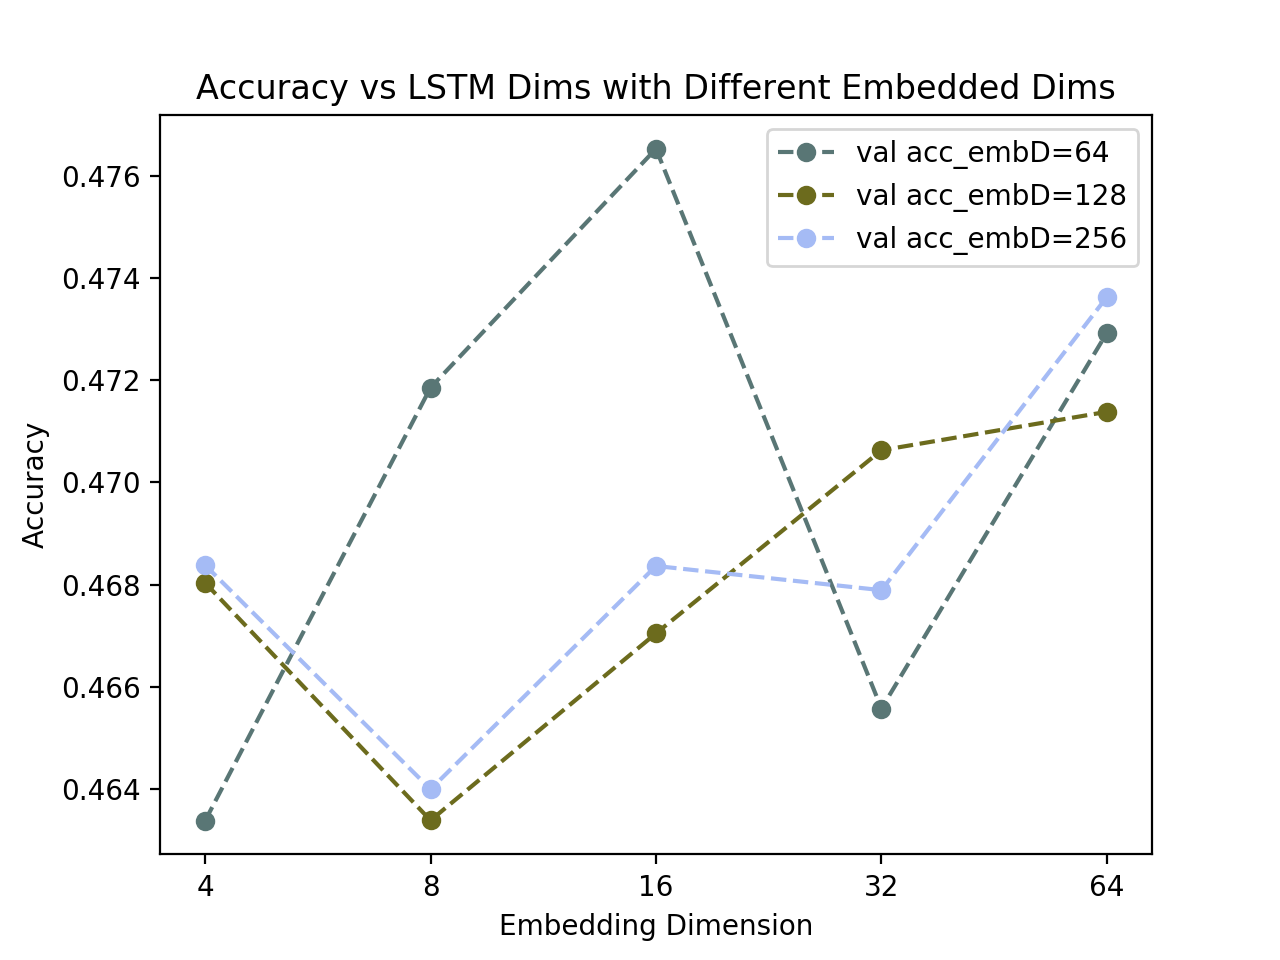

In [314]:
plt.figure()
x = lstmDims
xi = list(range(len(x)))

r = lambda: random.randint(0,255)

for embD in embeddingDims:
    vals = accs[accs[:, 4] == embD]
    plt.plot(xi, vals[:, 1], marker='o', linestyle='--', color='#%02X%02X%02X' % (r(),r(),r()), label='val acc_embD=%g'%embD)
plt.xlabel("Embedding Dimension")
plt.ylabel("Accuracy")
plt.xticks(xi, x)
plt.title("Accuracy vs LSTM Dims with Different Embedded Dims (LSTM)")
plt.legend()
plt.show()

In [318]:
colorss = [
    "#C0C0C0", 
    "#808080", 
    "#000000", 
    "#FF0000", 
    "#800000", 
    "#FFFF00", 
    "#808000", 
    "#00FF00", 
    "#008000", 
    "#00FFFF", 
    "#008080", 
    "#0000FF", 
    "#000080", 
    "#FF00FF", 
    "#800080"
]

<IPython.core.display.Javascript object>


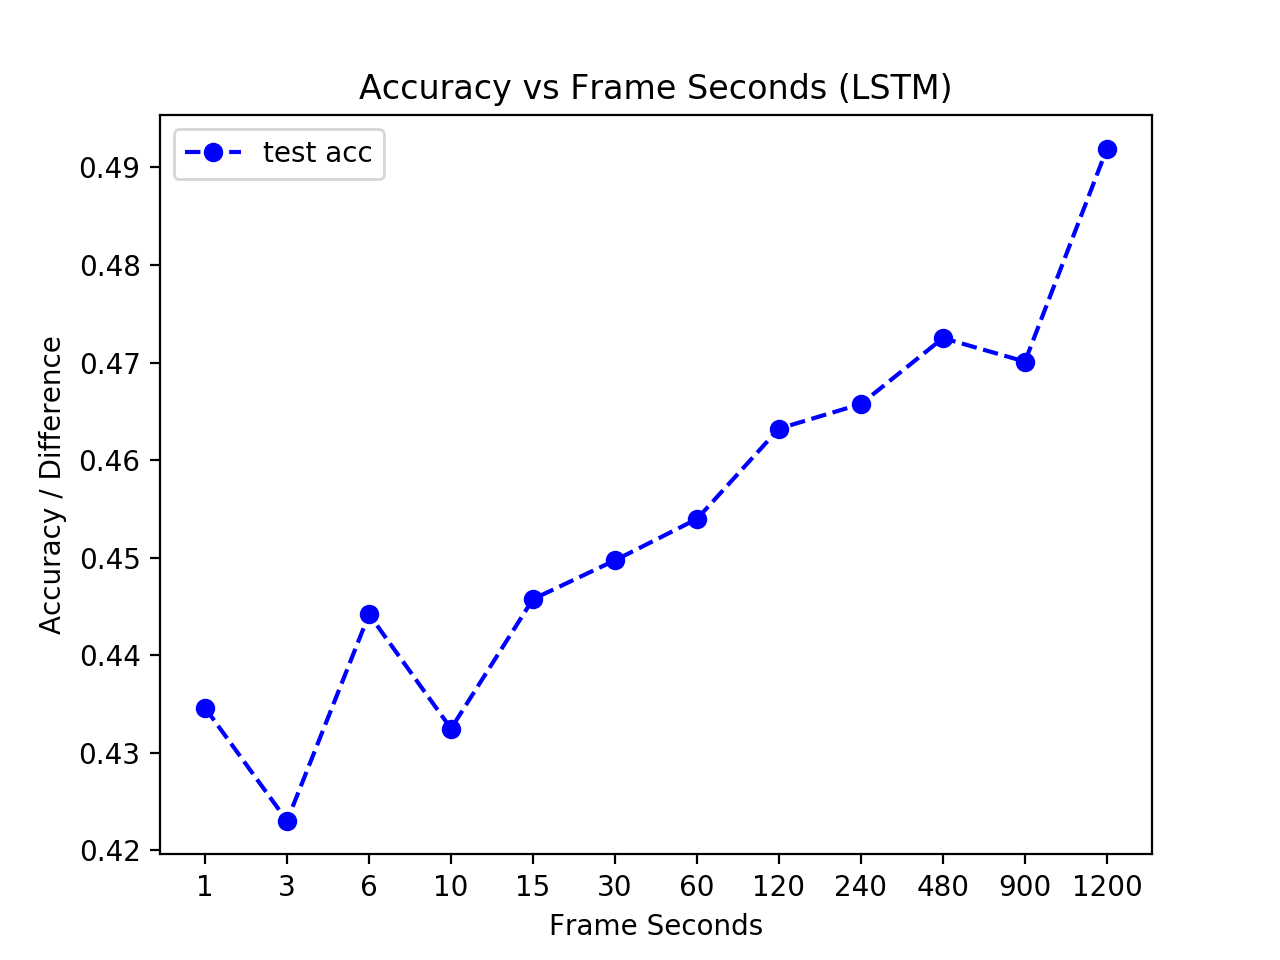

In [328]:
accs = np.array(accs)

plt.figure()
x = frameSecss
xi = list(range(len(x)))

r = lambda: np.random.choice(colorss)

# plt.plot(xi, accs[:, 0], marker='o', linestyle='--', color=r(), label='train acc')
plt.plot(xi, accs[:, 1], marker='o', linestyle='--', color=r(), label='test acc')
# plt.plot(xi, accs[:, 0] - accs[:, -2], marker='o', linestyle='--', color=r(), label='train acc - baseline')
# plt.plot(xi, accs[:, 1] - accs[:, -1], marker='o', linestyle='--', color=r(), label='test acc - baseline')

plt.xlabel("Frame Seconds")
plt.ylabel("Accuracy / Difference")
plt.xticks(xi, x)
plt.title("Accuracy vs Frame Seconds (LSTM)")
plt.legend()
plt.show()

## Figures:

### Trump Tweets Length

<IPython.core.display.Javascript object>


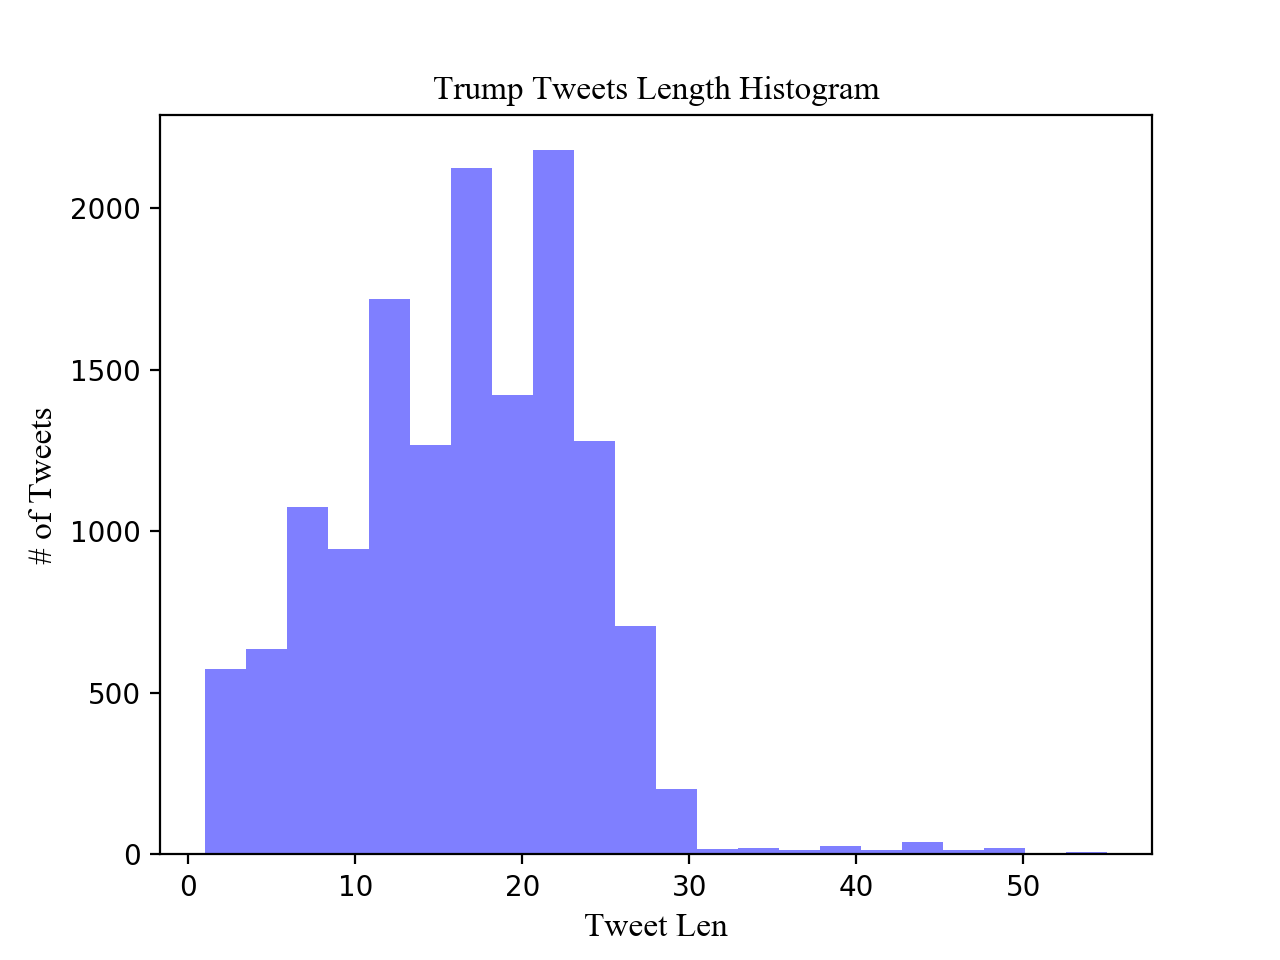

In [283]:
plt.figure()
tweetLen = [len(s.split(" ")) for s in X]
num_bins = 22
n, bins, patches = plt.hist(tweetLen, num_bins, facecolor='blue', alpha=0.5)
csfont = {'fontname':'Times New Roman', 'fontsize': 12}
plt.title("Trump Tweets Length Histogram", **csfont)
plt.xlabel("Tweet Len", **csfont)
plt.ylabel("# of Tweets", **csfont)
plt.show()

### Volatilities

<IPython.core.display.Javascript object>


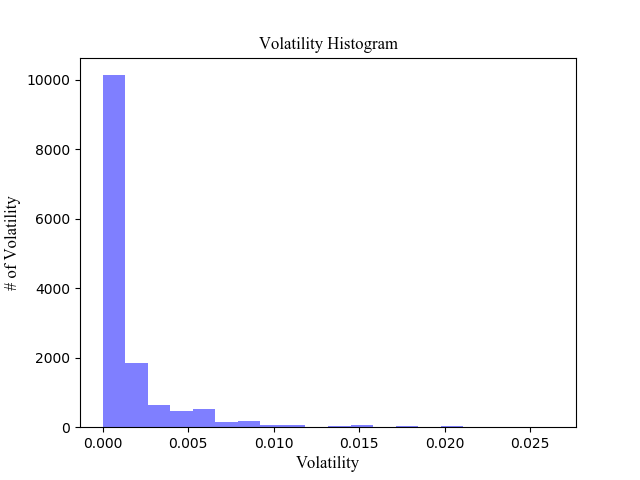

In [277]:
plt.figure()
_, y = getXy(data, sp_ticks_np, 60)
volatility = np.abs(y)

num_bins = 20
n, bins, patches = plt.hist(volatility, num_bins, facecolor='blue', alpha=0.5)
csfont = {'fontname':'Times New Roman', 'fontsize': 12}
plt.title("Volatility Histogram", **csfont)
plt.xlabel("Volatility", **csfont)
plt.ylabel("# of Volatility", **csfont)
plt.show()

In [261]:
frameSecss = [1, 3, 6, 10, 15, 30, 60, 120, 240, 480, 900, 20 * 60]
volatilities = []
for frameS in frameSecss:
    _, y = getXy(data, sp_ticks_np, frameS)
    volatilities.append(np.mean(np.abs(np.array(y))))

<IPython.core.display.Javascript object>


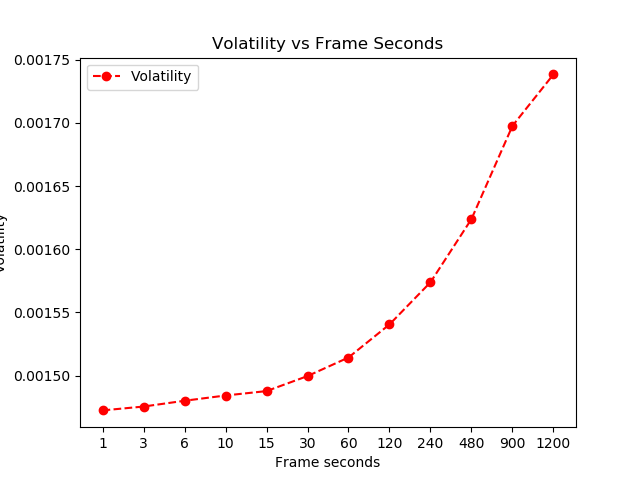

In [325]:
plt.figure()
x = frameSecss
xi = list(range(len(x)))
plt.plot(xi, volatilities, marker='o', linestyle='--', color='r', label='Volatility')
plt.xlabel("Frame seconds")
plt.ylabel("Volatility")
plt.xticks(xi, x)
plt.title("Volatility vs Frame Seconds")
plt.legend()
plt.show()